# Importazione Librerie e Dataset

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, accuracy_score

df = pd.read_csv('data/df_EDA')

# Encoding e rimozione per preparare il modello

In [6]:
#elimino la colonna ridondante di loan_percent_income
df = df.drop(columns=['loan_percent_income'])

# Label Encoding su variabili categoriche non ordinarie
# Colonne da encodare
categorical_cols = ['person_home_ownership', 'loan_intent']

# Applichiamo LabelEncoder
label_encoders = {}  # Per salvare i mapping

for col in categorical_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le  # Salva il LabelEncoder per futuri decoding o interpretazioni

df_encoded = df

#### Bilanciamento e Split

In [7]:
# separazione x e y
X = df.drop('loan_status', axis=1)
y = df['loan_status']

#normalizziamo i valori
y.value_counts(normalize=True)


loan_status
0    0.756097
1    0.243903
Name: proportion, dtype: float64

# Decision Tree No-Pruning

#### Costruzione dell'albero senza pruning

In [8]:
# Divisione del dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Costruzione del modello Decision Tree senza pruning
dt_model = DecisionTreeClassifier(random_state=42, class_weight='balanced')

#### Allenamento e visualizzazione dell’albero

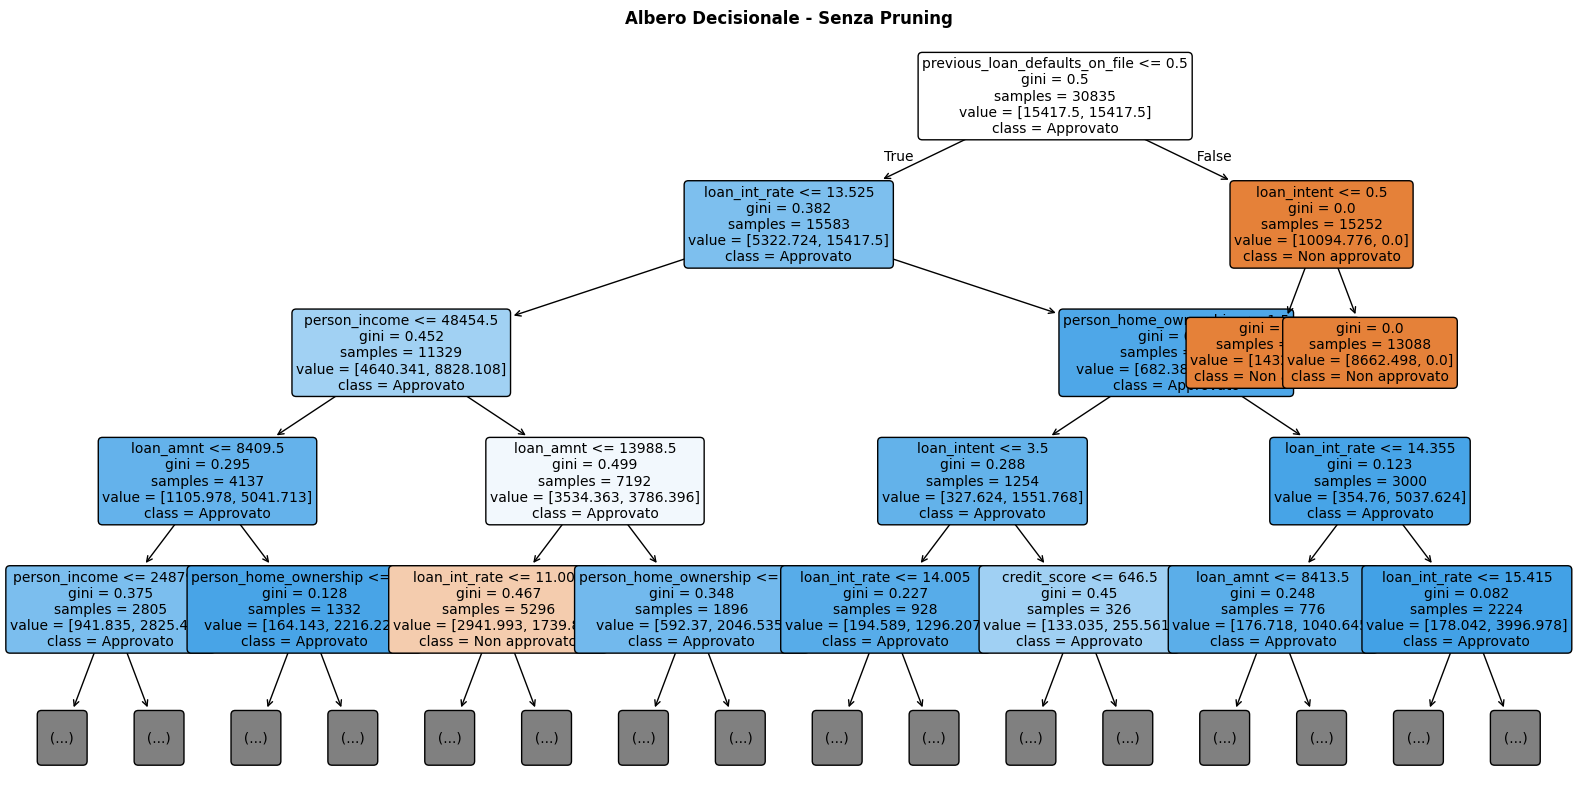

In [9]:
# Allenamento del modello
dt_model.fit(X_train, y_train)

# Visualizzazione dell’albero decisionale
plt.figure(figsize=(20, 10))
plot_tree(dt_model,
          max_depth=4,  # limita profondità del grafico (non del modello)
          feature_names=X.columns,
          class_names=['Non approvato', 'Approvato'],
          filled=True, # colora i nodi in base alla classe predominante
          rounded=True,  # bordi arrotondati per migliorare la leggibilità
          fontsize=10)
plt.title("Albero Decisionale - Senza Pruning", weight='bold')
plt.show()


#### Predizione e valutazione delle performance

In [10]:
# Predizioni
y_pred = dt_model.predict(X_test)

# Accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy del modello: {accuracy:.3f}")

Accuracy del modello: 0.893


#### Matrice di confusione No-Pruning

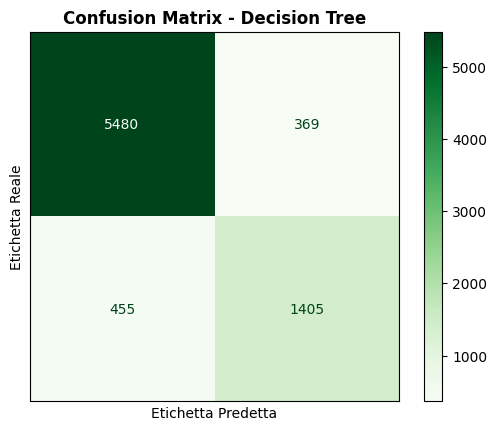

In [11]:
conf_matrix = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=dt_model.classes_)
disp.plot(cmap='Greens')
plt.title("Confusion Matrix - Decision Tree", weight='bold') 
plt.xlabel("Etichetta Predetta")
plt.ylabel("Etichetta Reale")
# Rimuove i numeri delle tacche da entrambi gli assi per pulizia visiva
plt.xticks([])
plt.yticks([])
plt.show()

#### Calcolo AUC e curva ROC No-Pruning

AUC-ROC: 0.846


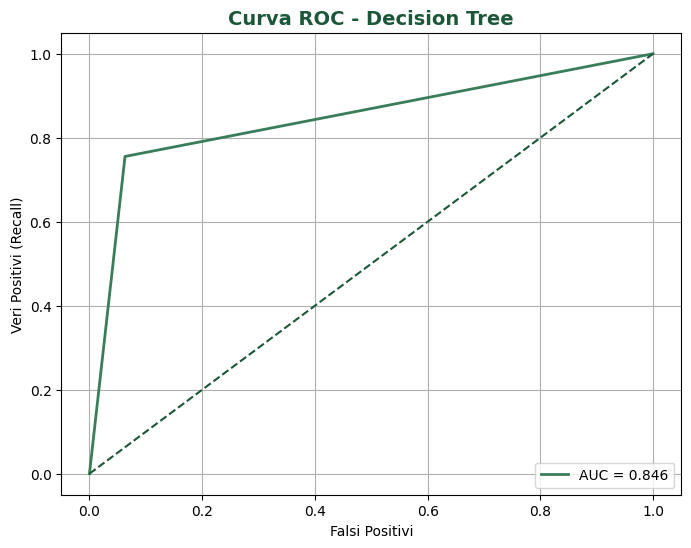

In [12]:
# Calcolo AUC e curva Roc
y_proba = dt_model.predict_proba(X_test)[:, 1]
auc_score = roc_auc_score(y_test, y_proba)
print(f"AUC-ROC: {auc_score:.3f}")

fpr, tpr, thresholds = roc_curve(y_test, y_proba)

# Plot ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'AUC = {auc_score:.3f}', color='#397d5a', linewidth=2)
plt.plot([0, 1], [0, 1], linestyle='--', color='#1c5739')
plt.xlabel('Falsi Positivi')
plt.ylabel('Veri Positivi (Recall)')
plt.title('Curva ROC - Decision Tree', fontsize=14, fontweight='bold', color='#1c5739')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

+ Curva verde: mostra come varia il Recall (TPR) al variare della soglia decisionale del modello.
+ Linea nera tratteggiata: rappresenta un modello casuale, con AUC (area under curve) = 0.5 che serve da confronto.
+ Il fatto che la curva sia ben sopra la diagonale indica che il modello ha buone capacità di discriminare tra le due classi (prestito rimborsato vs inadempienza).
+ L’AUC = 0.846 indica che il modello riesce, nell’84.6% dei casi, a dare un punteggio di rischio più alto a un caso realmente problematico (cioè chi rischia davvero di non rimborsare il prestito) rispetto a uno non problematico (cioè chi è affidabile).

# Costruzione Decision Tree Pre-Pruning

#### Costruzione e validazione del modello (con pre-pruning)

In [13]:
# Divisione train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Costruzione del modello con pre-pruning
dtree = DecisionTreeClassifier(
    max_depth=6,              # Profondità massima dell’albero
    min_samples_split=20,     # Minimo campioni per dividere un nodo
    min_samples_leaf=10,      # Minimo campioni in ogni foglia
    random_state=42
)

# Cross-Validation (valutazione della bontà del modello sul training set)
cv_scores = cross_val_score(dtree, X_train, y_train, cv=5)
print("Accuracy media cross-validation:", round(cv_scores.mean(), 3))

Accuracy media cross-validation: 0.9


#### Allenamento e visualizzazione dell’albero pre-pruned

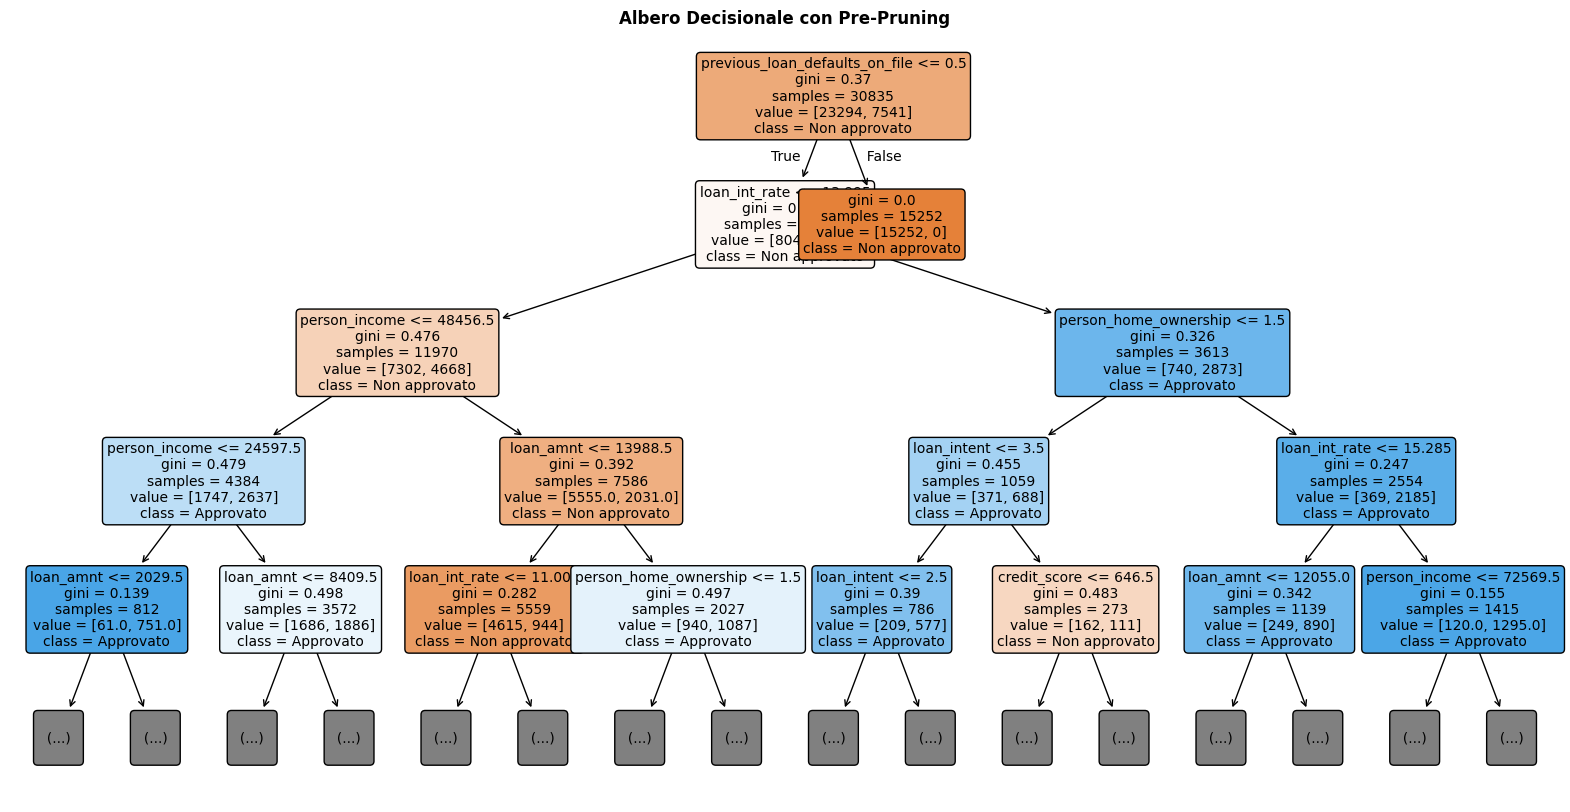

In [14]:
# Allenamento del modello finale sul training set
dtree.fit(X_train, y_train)

# Visualizzazione dell’albero
plt.figure(figsize=(20, 10))
plot_tree(dtree,
          max_depth=4,  # per leggibilità nel grafico
          feature_names=X.columns,
          class_names=['Non approvato', 'Approvato'],
          filled=True,
          rounded=True,
          fontsize=10)
plt.title("Albero Decisionale con Pre-Pruning", weight='bold')
plt.show()

#### Predizione e valutazione delle performance

In [15]:
# Predizioni sul test set
y_pred = dtree.predict(X_test)

# Accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy del modello: {round(accuracy, 3)}")

# Report classificazione
print(classification_report(y_test, y_pred))



Accuracy del modello: 0.898
              precision    recall  f1-score   support

           0       0.91      0.96      0.93      5849
           1       0.86      0.69      0.77      1860

    accuracy                           0.90      7709
   macro avg       0.88      0.83      0.85      7709
weighted avg       0.90      0.90      0.89      7709



#### Matrice di confusione Pre-Pruning

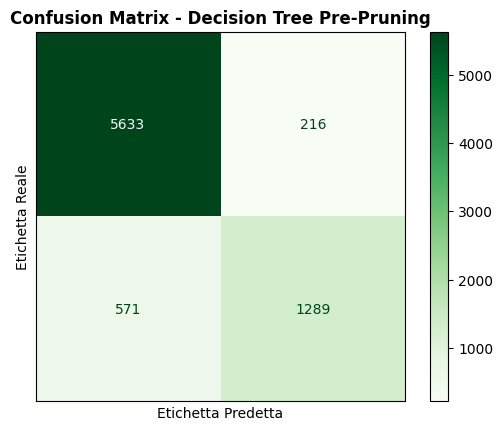

In [16]:
# Matrice di Confusione
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=dtree.classes_)
disp.plot(cmap='Greens')
plt.title("Confusion Matrix - Decision Tree Pre-Pruning", weight='bold')
plt.xlabel("Etichetta Predetta")
plt.ylabel("Etichetta Reale")
plt.xticks([])
plt.yticks([])
plt.show()

#### Curva Roc Pre-Pruning

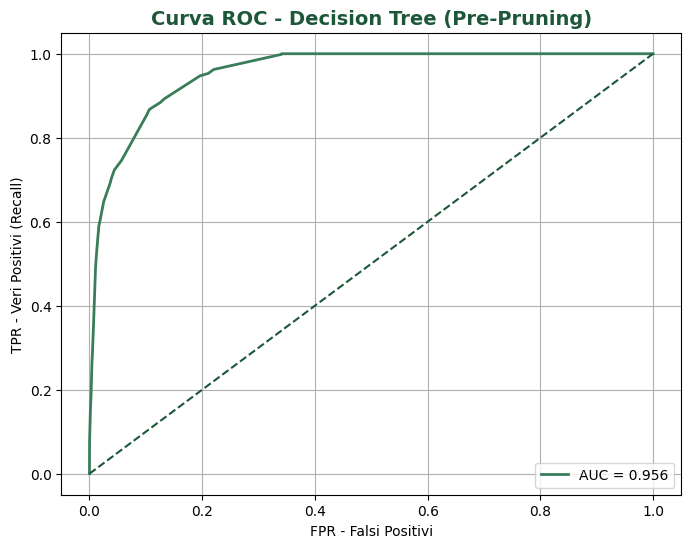

In [17]:
y_proba = dtree.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_proba)
auc_score = roc_auc_score(y_test, y_proba)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'AUC = {auc_score:.3f}', color='#397d5a', linewidth=2)
plt.plot([0, 1], [0, 1], linestyle='--', color='#1c5739')
plt.xlabel('FPR - Falsi Positivi')
plt.ylabel('TPR - Veri Positivi (Recall)')
plt.title('Curva ROC - Decision Tree (Pre-Pruning)', fontsize=14, fontweight='bold', color='#1c5739')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


+ Curva verde: mostra come varia il Recall (TPR) al variare della soglia decisionale del modello.
+ Linea verde tratteggiata: rappresenta un classificatore casuale, con AUC = 0.5, usato come riferimento.
+ La curva ROC è molto vicina al margine superiore sinistro: questo indica un’eccellente capacità del modello di distinguere tra i due gruppi (prestiti rimborsati vs inadempienze).
+ L’AUC = 0.949 significa che il modello, nel 94.9% dei casi, assegna un punteggio di rischio più alto a un utente realmente a rischio di default rispetto a uno affidabile.

Rispetto al modello senza pruning, il pre-pruning ha migliorato nettamente la discriminazione, pur riducendo la complessità dell’albero.

#### Importanza delle feature

C:\Users\Francesca\AppData\Local\Temp\ipykernel_19552\3278800020.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=importances.values, y=importances.index, palette='Greens_r')


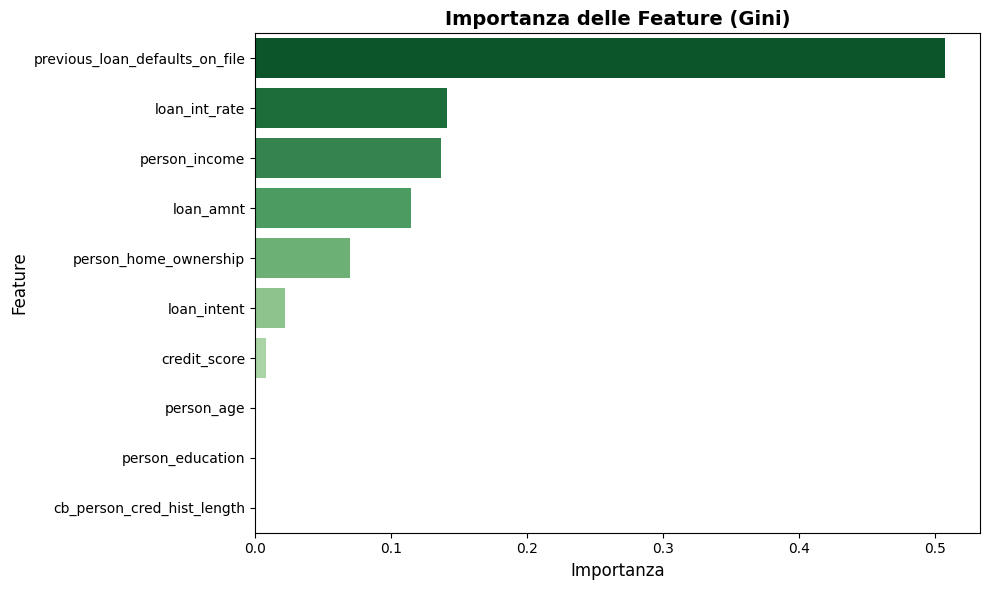

In [18]:
importances = pd.Series(dtree.feature_importances_, index=X.columns)
importances = importances.sort_values(ascending=False)

plt.figure(figsize=(10,6))
sns.barplot(x=importances.values, y=importances.index, palette='Greens_r')
plt.title('Importanza delle Feature (Gini)', fontsize=14, fontweight='bold')
plt.xlabel('Importanza', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.show()

# Costruzione Decision Tree Post-Pruning

#### Calcolo di ccp_alpha e grafico Accuracy vs ccp_alpha

Accuracy (senza pruning): 0.890


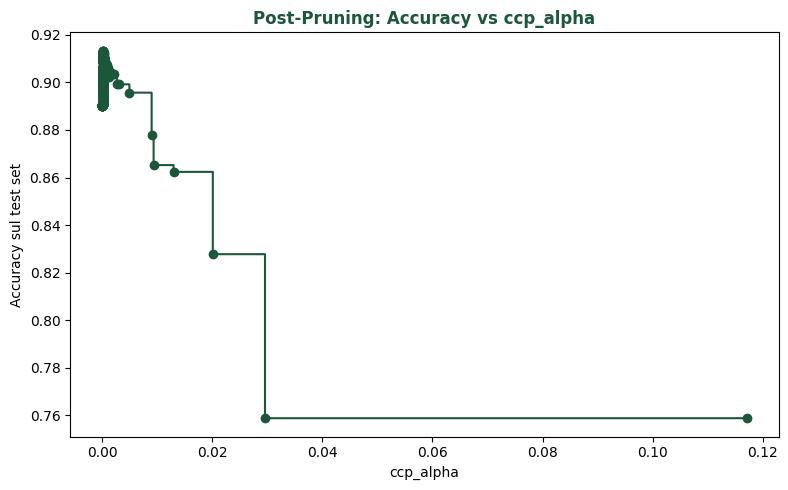

In [19]:
# Colori personalizzati
color_verde_scuro = '#1c5739'
color_verde_chiaro = '#397d5a'

# Divisione del dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Costruzione albero base (senza pruning)
dtree = DecisionTreeClassifier(random_state=42)
dtree.fit(X_train, y_train)
y_pred = dtree.predict(X_test)
print(f"Accuracy (senza pruning): {accuracy_score(y_test, y_pred):.3f}")

# Calcolo dei valori di ccp_alpha
path = dtree.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas = path.ccp_alphas

# Costruzione di un albero per ogni alpha
trees = []
for ccp_alpha in ccp_alphas:
    clf = DecisionTreeClassifier(random_state=42, ccp_alpha=ccp_alpha)
    clf.fit(X_train, y_train)
    trees.append(clf)

# Accuracy per ogni albero sul test set
acc_scores = [accuracy_score(y_test, clf.predict(X_test)) for clf in trees]

# Grafico Accuracy vs ccp_alpha
plt.figure(figsize=(8, 5))
plt.plot(ccp_alphas, acc_scores, marker='o', color=color_verde_scuro, drawstyle="steps-post")
plt.xlabel("ccp_alpha")
plt.ylabel("Accuracy sul test set")
plt.title("Post-Pruning: Accuracy vs ccp_alpha", weight='bold', color=color_verde_scuro)
plt.tight_layout()
plt.show()

#### Costruzione e visualizzazione dell’albero Post-Pruning

Miglior ccp_alpha: 0.0001052244071540325


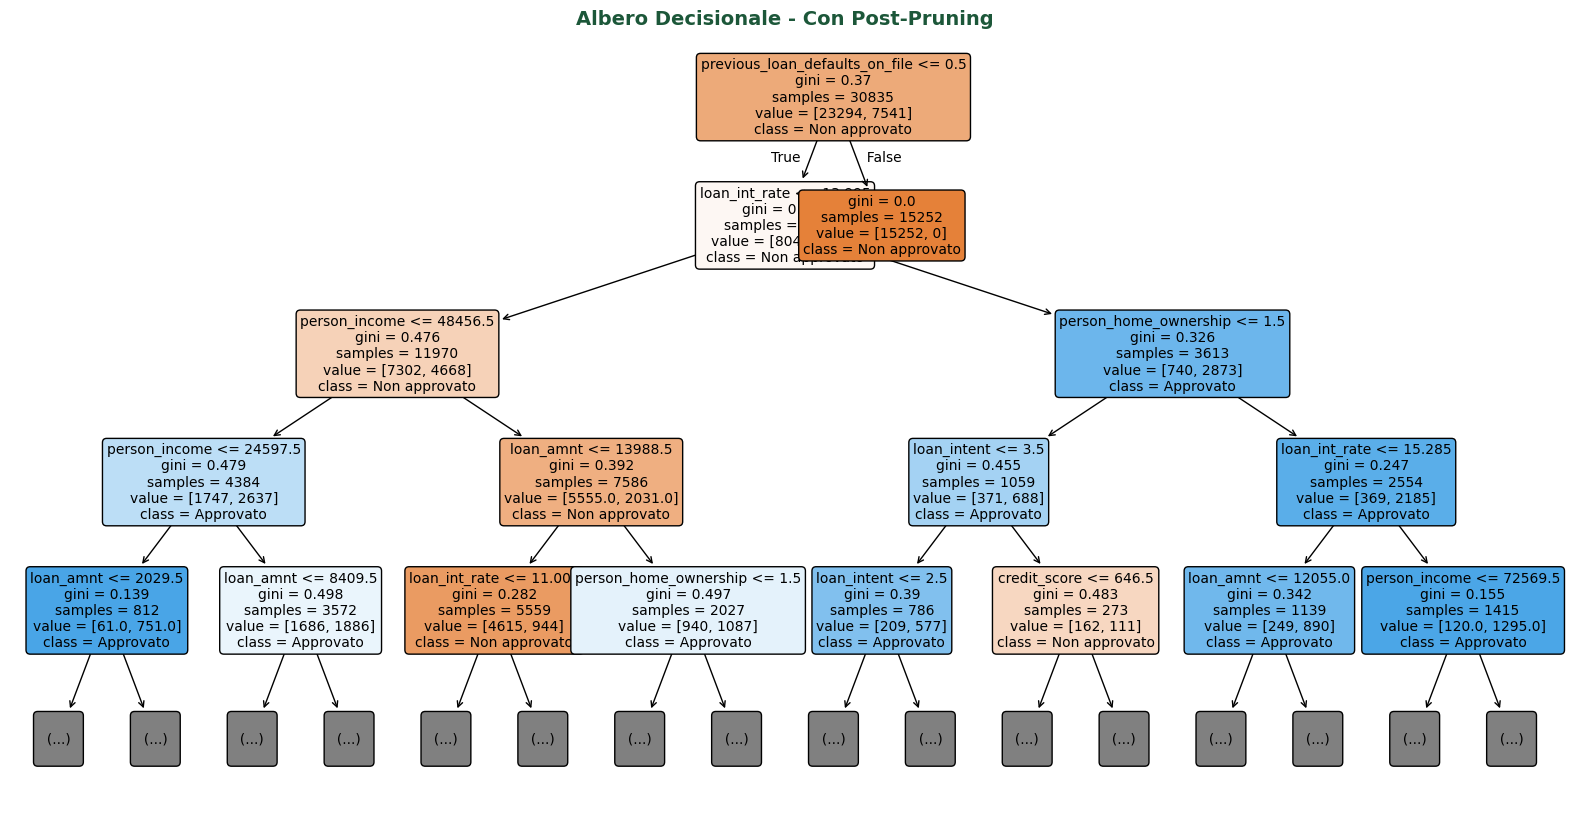

In [20]:
# Selezione del miglior ccp_alpha
best_ccp_alpha = ccp_alphas[acc_scores.index(max(acc_scores))]
print(f"Miglior ccp_alpha: {best_ccp_alpha}")

# Creazione dell'albero potato finale
final_tree = DecisionTreeClassifier(random_state=42, ccp_alpha=best_ccp_alpha)
final_tree.fit(X_train, y_train)

# Visualizzazione dell'albero potato
plt.figure(figsize=(20, 10))
plot_tree(final_tree,
          feature_names=X.columns,
          class_names=['Non approvato', 'Approvato'],
          filled=True,
          rounded=True,
          max_depth=4,
          fontsize=10)
plt.title("Albero Decisionale - Con Post-Pruning", fontsize=14, fontweight='bold', color=color_verde_scuro)
plt.show()

#### Allenamento e predizione finale

In [21]:
# Predizione sui dati di test
y_pred_final = final_tree.predict(X_test)

# Accuracy finale
acc = accuracy_score(y_test, y_pred_final)
print(f"Accuracy (con post-pruning): {acc:.3f}")

Accuracy (con post-pruning): 0.913


#### Matrice di confusione albero Post-Pruning

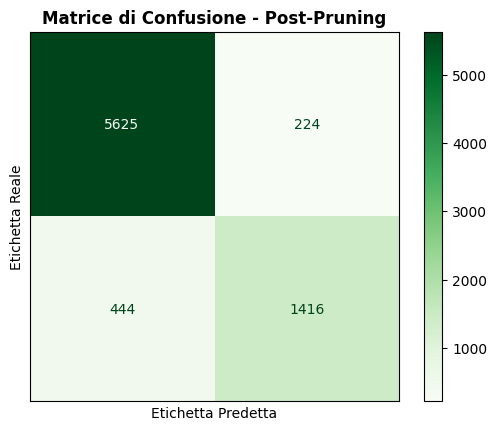

In [22]:
# Matrice di Confusione
conf_matrix = confusion_matrix(y_test, y_pred_final)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=['Non approvato', 'Approvato'])
disp.plot(cmap='Greens')
plt.title("Matrice di Confusione - Post-Pruning", weight='bold')
plt.xlabel("Etichetta Predetta")
plt.ylabel("Etichetta Reale")
plt.grid(False)             # Rimuove le righe della griglia
plt.xticks([])              # Rimuove le tacche sull'asse x
plt.yticks([])              # Rimuove le tacche sull'asse y
plt.show()

#### Curva Roc Post-Pruning

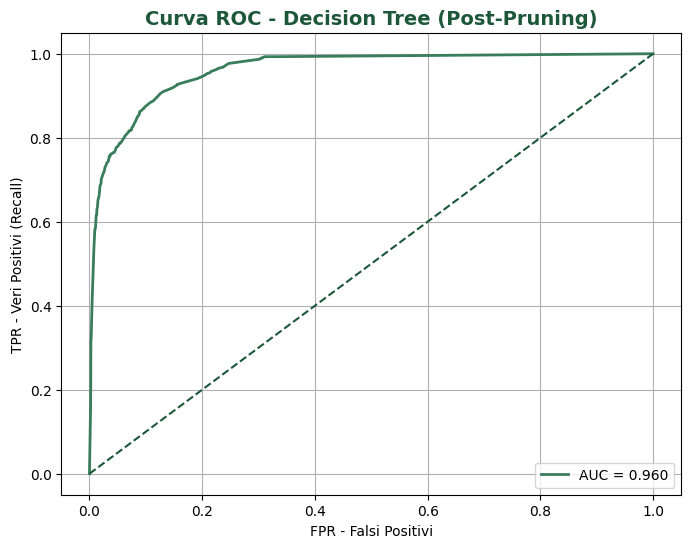

In [23]:
# Curva ROC
y_proba_final = final_tree.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_proba_final)
auc_score = roc_auc_score(y_test, y_proba_final)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'AUC = {auc_score:.3f}', color=color_verde_chiaro, linewidth=2)
plt.plot([0, 1], [0, 1], linestyle='--', color=color_verde_scuro)
plt.xlabel('FPR - Falsi Positivi')
plt.ylabel('TPR - Veri Positivi (Recall)')
plt.title('Curva ROC - Decision Tree (Post-Pruning)', fontsize=14, fontweight='bold', color=color_verde_scuro)
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

+ Curva verde: mostra come varia il Recall (TPR) al cambiare della soglia di classificazione.
+ Linea verde tratteggiata: rappresenta un modello casuale (AUC = 0.5), utilizzato come benchmark minimo.
+ La curva è ancora più vicina all’angolo superiore sinistro, segno che il modello ha un’ottima capacità di identificare correttamente i casi problematici.
+ L’AUC = 0.959 indica che il modello riesce, nel 95.9% dei casi, a dare un punteggio di rischio più alto a un soggetto effettivamente a rischio rispetto a uno affidabile.

Questo è il miglior risultato tra i tre modelli, dimostrando che il post-pruning non solo semplifica l’albero, ma migliora anche la performance globale nella discriminazione tra classi.

# Confronto Modelli

#### Curva ROC Albero Senza Pruning vs Post-Pruning (slide)

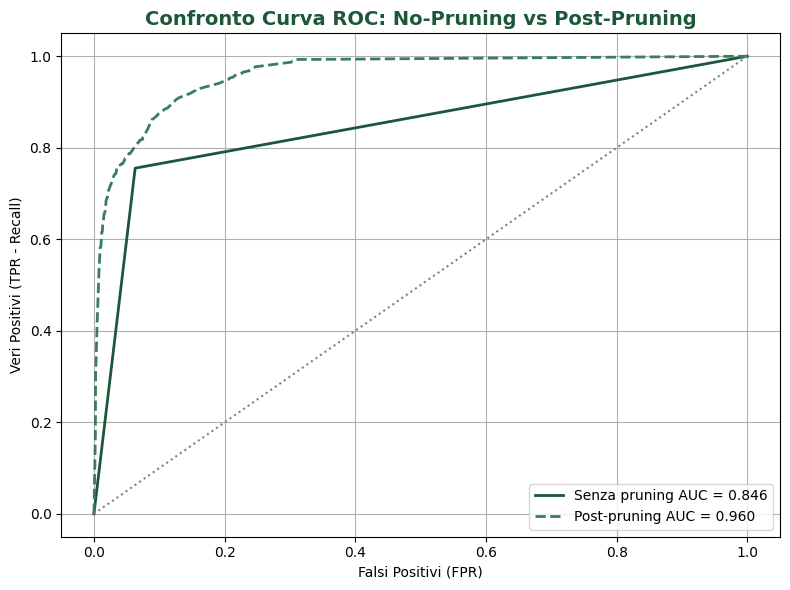

In [24]:
# Probabilità per modello senza pruning
y_proba_nopruning = dt_model.predict_proba(X_test)[:, 1]
fpr_nop, tpr_nop, _ = roc_curve(y_test, y_proba_nopruning)
roc_auc_nop = roc_auc_score(y_test, y_proba_nopruning)

# Probabilità per modello post-pruning
y_proba_post = final_tree.predict_proba(X_test)[:, 1]
fpr_post, tpr_post, _ = roc_curve(y_test, y_proba_post)
roc_auc_post = roc_auc_score(y_test, y_proba_post)

# Plot ROC con confronto
plt.figure(figsize=(8, 6))
plt.plot(fpr_nop, tpr_nop, label=f'Senza pruning AUC = {roc_auc_nop:.3f}', color='#1c5739', linewidth=2)
plt.plot(fpr_post, tpr_post, label=f'Post-pruning AUC = {roc_auc_post:.3f}', color='#397d5a', linestyle='--', linewidth=2)
plt.plot([0, 1], [0, 1], linestyle=':', color='gray')

plt.xlabel("Falsi Positivi (FPR)")
plt.ylabel("Veri Positivi (TPR - Recall)")
plt.title("Confronto Curva ROC: No-Pruning vs Post-Pruning", fontsize=14, fontweight='bold', color='#1c5739')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()

#### Grafico a barre

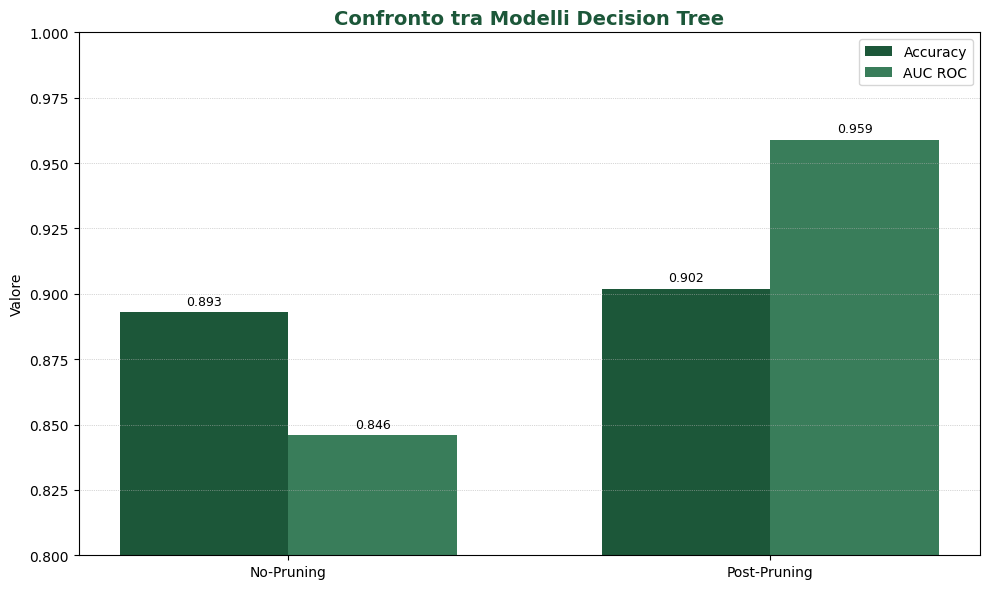

In [25]:
# Etichette dei modelli
modelli = ['No-Pruning', 'Post-Pruning']

# Valori corrispondenti
accuracy = [0.893, 0.902]
auc = [0.846, 0.959]

# Posizioni delle barre
x = np.arange(len(modelli))
width = 0.35

# Crea il grafico
fig, ax = plt.subplots(figsize=(10, 6))

# Barre per Accuracy
bars1 = ax.bar(x - width/2, accuracy, width, label='Accuracy', color='#1c5739')

# Barre per AUC ROC
bars2 = ax.bar(x + width/2, auc, width, label='AUC ROC', color='#397d5a')

# Etichette e titolo
ax.set_ylabel('Valore')
ax.set_title('Confronto tra Modelli Decision Tree', fontsize=14, fontweight='bold', color='#1c5739')
ax.set_xticks(x)
ax.set_xticklabels(modelli)
ax.set_ylim(0.80, 1.00)
ax.legend()

# Etichette sopra ogni barra
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.3f}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords='offset points',
                    ha='center', va='bottom', fontsize=9)

# Griglia orizzontale leggera
plt.grid(axis='y', linestyle=':', linewidth=0.5)
plt.tight_layout()
plt.show()

+ Barre a sinistra (verde scuro): Accuracy sul test set

+ Barre a destra (verde chiaro): AUC ROC, cioè capacità discriminante

### Conclusioni fra i due modelli

> Il modello post-pruning è nettamente superiore in termini di AUC (0.959 vs 0.846).

> La curva del post-pruning è più alta e vicina al bordo superiore sinistro, che indica una migliore capacità di discriminare tra le classi (cioè tra chi ripagherà e chi no).

> Questo significa che è più affidabile nel classificare correttamente i prestiti a rischio.

> Inoltre, è più semplice e più generalizzabile, quindi più adatto anche a nuovi dati.

    IL MIGLIOR MODELLO FRA I DUE E' QUELLO DEL POST-PRUNING.


# Confronto fra i tre modelli

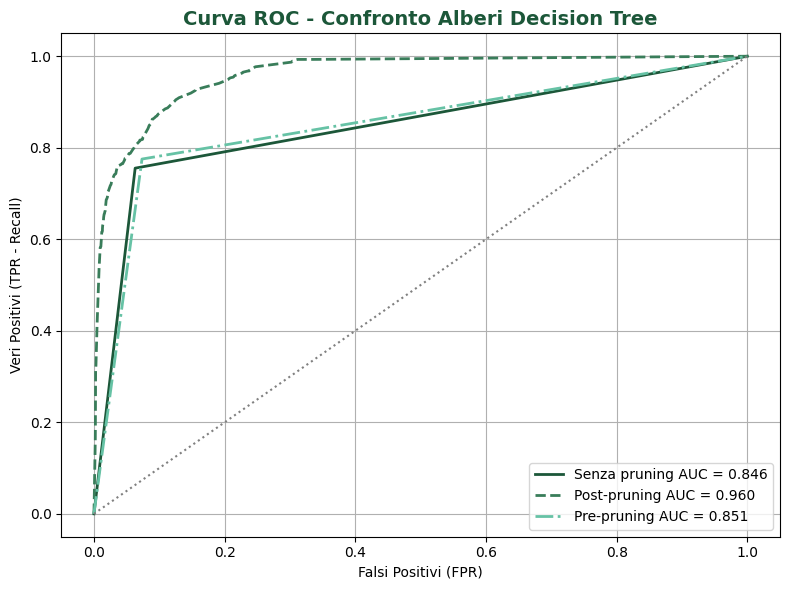

In [26]:
# Probabilità per ogni modello
y_proba_nop = dt_model.predict_proba(X_test)[:, 1]       # senza pruning
y_proba_post = final_tree.predict_proba(X_test)[:, 1]    # post-pruning
y_proba_pre = dtree.predict_proba(X_test)[:, 1]          # pre-pruning

# ROC curve
fpr_nop, tpr_nop, _ = roc_curve(y_test, y_proba_nop)
fpr_post, tpr_post, _ = roc_curve(y_test, y_proba_post)
fpr_pre, tpr_pre, _ = roc_curve(y_test, y_proba_pre)

# AUC
auc_nop = roc_auc_score(y_test, y_proba_nop)
auc_post = roc_auc_score(y_test, y_proba_post)
auc_pre = roc_auc_score(y_test, y_proba_pre)

# Grafico
plt.figure(figsize=(8, 6))
plt.plot(fpr_nop, tpr_nop, label=f'Senza pruning AUC = {auc_nop:.3f}', color='#1c5739', linewidth=2)
plt.plot(fpr_post, tpr_post, label=f'Post-pruning AUC = {auc_post:.3f}', color='#397d5a', linestyle='--', linewidth=2)
plt.plot(fpr_pre, tpr_pre, label=f'Pre-pruning AUC = {auc_pre:.3f}', color='#66c2a5', linestyle='-.', linewidth=2)
plt.plot([0, 1], [0, 1], linestyle=':', color='gray')

plt.xlabel('Falsi Positivi (FPR)')
plt.ylabel('Veri Positivi (TPR - Recall)')
plt.title('Curva ROC - Confronto Alberi Decision Tree', fontsize=14, fontweight='bold', color='#1c5739')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()

#### Grafici a barre di confronto

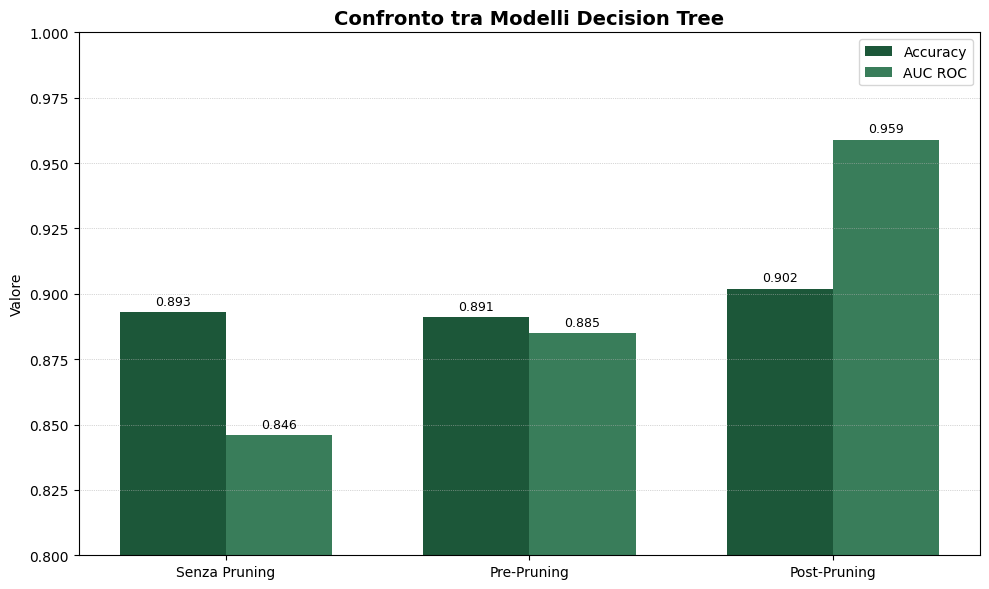

In [27]:
# Etichette dei modelli
modelli = ['Senza Pruning', 'Pre-Pruning', 'Post-Pruning']

# Valori di Accuracy e AUC ROC (sostituiscili con i tuoi se diversi)
accuracy = [0.893, 0.891, 0.902]
auc = [0.846, 0.885, 0.959]

# Posizioni delle barre
x = np.arange(len(modelli))
width = 0.35  # Larghezza delle barre

# Crea il grafico
fig, ax = plt.subplots(figsize=(10, 6))

# Barre per Accuracy
bars1 = ax.bar(x - width/2, accuracy, width, label='Accuracy', color='#1c5739')

# Barre per AUC ROC
bars2 = ax.bar(x + width/2, auc, width, label='AUC ROC', color='#397d5a')

# Etichette e titolo
ax.set_ylabel('Valore')
ax.set_title('Confronto tra Modelli Decision Tree', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(modelli)
ax.set_ylim(0.80, 1.00)
ax.legend()

# Etichette sopra ogni barra
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.3f}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),  # spostamento verticale
                    textcoords='offset points',
                    ha='center', va='bottom', fontsize=9)

# Griglia orizzontale leggera
plt.grid(axis='y', linestyle=':', linewidth=0.5)
plt.tight_layout()
plt.show()


+ Barre a sinistra (verde scuro): Accuracy sul test set

+ Barre a destra (verde chiaro): AUC ROC, cioè capacità discriminante

# CONCLUSIONI CON TUTTI E TRE I MODELLI

> Il modello post-pruning vince su entrambi i fronti: ha accuracy e AUC più alti.

> Il modello senza pruning ha buona accuracy ma AUC più bassa che è un segno di potenziale overfitting.

> Il pre-pruning è più bilanciato: AUC intermedia e struttura più semplice.


    IL MIGLIOR MODELLO FRA I TRE E' QUELLO DEL POST-PRUNING.